<a href="https://colab.research.google.com/github/Jefaf/DetectorFakeNewsEspanol/blob/master/FakeNewsYo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import spacy
import tensorflow as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns



In [59]:
!pip install Unidecode

In [60]:
import unidecode

Importación del *dataset

In [61]:
news_dataset = pd.read_csv('/content/SpanishNews-V3.csv', sep=';')

In [62]:
news_dataset.isnull().sum()

ID           0
CATEGORY     0
TOPICS       0
SOURCE       7
HEADLINE    72
TEXT         0
LINK         3
dtype: int64

In [63]:
news_dataset.dtypes

ID           int64
CATEGORY      bool
TOPICS      object
SOURCE      object
HEADLINE    object
TEXT        object
LINK        object
dtype: object

In [64]:
news_dataset["TEXT"].str.len().max()
news_dataset["TEXT"].str.len().min()

261

In [65]:
# Reemplazar los valores nulos port empty strings
news_dataset = news_dataset.fillna('')

In [66]:
news_dataset.head()

,ID,CATEGORY,TOPICS,SOURCE,HEADLINE,TEXT,LINK
0,1,True,Covid-19,El Economista,Covid-19: mentiras que matan,El control de la Covid-19 no es sólo un tema d...,https://www.eleconomista.com.mx/opinion/Covid-...
1,2,False,Política,El matinal,El Gobierno podrá acceder a las IPs de los móv...,El Gobierno de Pedro Sánchez y Pablo Iglesias ...,https://www.elmatinal.com/espana-ultima-hora/e...
2,3,True,Política,El País,La comunidad musulmana catalana denuncia a Vox...,Las tres federaciones que agrupan al 90% de la...,https://elpais.com/espana/elecciones-catalanas...
3,4,False,Política,AFPFactual,,Se han dado a conocer los datos electorales pr...,https://perma.cc/GYE6-SPMB
4,5,True,Sociedad,La Republica,El censo poblacional 2018 tendrá un costo de $...,La primera fase del censo será virtual y solo ...,https://www.larepublica.co/economia/el-censo-p...


In [67]:
# Contatenar el Headline y el Text
news_dataset['CONTENT'] = news_dataset['HEADLINE']+' '+news_dataset['TEXT']

In [68]:
news_dataset.head(5)

,ID,CATEGORY,TOPICS,SOURCE,HEADLINE,TEXT,LINK,CONTENT
0,1,True,Covid-19,El Economista,Covid-19: mentiras que matan,El control de la Covid-19 no es sólo un tema d...,https://www.eleconomista.com.mx/opinion/Covid-...,Covid-19: mentiras que matan El control de la ...
1,2,False,Política,El matinal,El Gobierno podrá acceder a las IPs de los móv...,El Gobierno de Pedro Sánchez y Pablo Iglesias ...,https://www.elmatinal.com/espana-ultima-hora/e...,El Gobierno podrá acceder a las IPs de los móv...
2,3,True,Política,El País,La comunidad musulmana catalana denuncia a Vox...,Las tres federaciones que agrupan al 90% de la...,https://elpais.com/espana/elecciones-catalanas...,La comunidad musulmana catalana denuncia a Vox...
3,4,False,Política,AFPFactual,,Se han dado a conocer los datos electorales pr...,https://perma.cc/GYE6-SPMB,Se han dado a conocer los datos electorales p...
4,5,True,Sociedad,La Republica,El censo poblacional 2018 tendrá un costo de $...,La primera fase del censo será virtual y solo ...,https://www.larepublica.co/economia/el-censo-p...,El censo poblacional 2018 tendrá un costo de $...


In [69]:
news_dataset["LENGHT"]=news_dataset["CONTENT"].str.len()
news_dataset.head()

,ID,CATEGORY,TOPICS,SOURCE,HEADLINE,TEXT,LINK,CONTENT,LENGHT
0,1,True,Covid-19,El Economista,Covid-19: mentiras que matan,El control de la Covid-19 no es sólo un tema d...,https://www.eleconomista.com.mx/opinion/Covid-...,Covid-19: mentiras que matan El control de la ...,4605
1,2,False,Política,El matinal,El Gobierno podrá acceder a las IPs de los móv...,El Gobierno de Pedro Sánchez y Pablo Iglesias ...,https://www.elmatinal.com/espana-ultima-hora/e...,El Gobierno podrá acceder a las IPs de los móv...,1916
2,3,True,Política,El País,La comunidad musulmana catalana denuncia a Vox...,Las tres federaciones que agrupan al 90% de la...,https://elpais.com/espana/elecciones-catalanas...,La comunidad musulmana catalana denuncia a Vox...,4195
3,4,False,Política,AFPFactual,,Se han dado a conocer los datos electorales pr...,https://perma.cc/GYE6-SPMB,Se han dado a conocer los datos electorales p...,1235
4,5,True,Sociedad,La Republica,El censo poblacional 2018 tendrá un costo de $...,La primera fase del censo será virtual y solo ...,https://www.larepublica.co/economia/el-censo-p...,El censo poblacional 2018 tendrá un costo de $...,1787


In [70]:
news_dataset['LENGHT'].describe().to_frame()

,LENGHT
count,572.000000
mean,3253.491259
std,2685.382267
min,262.000000
25%,1578.500000
50%,2520.500000
75%,4059.000000
max,25871.000000


In [71]:
news_dataset['CATEGORY'].value_counts()

True     286
False    286
Name: CATEGORY, dtype: int64

Text(0, 0.5, 'Cantidad')

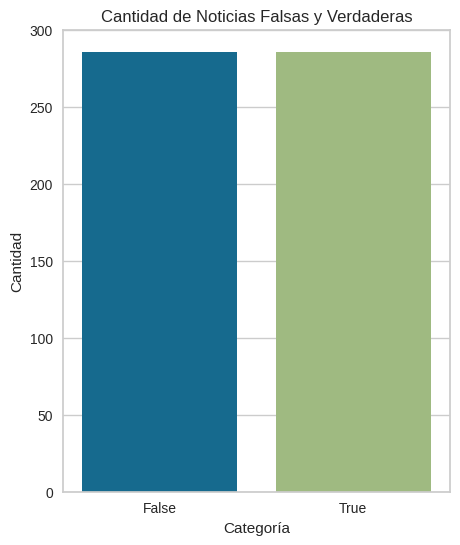

In [72]:
plt.figure(figsize = (5,6))
sns.countplot(x = 'CATEGORY', data = news_dataset)
plt.title("Cantidad de Noticias Falsas y Verdaderas")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")

In [73]:
news_dataset['TOPICS'].value_counts().count()

7

<Axes: xlabel='TOPICS', ylabel='count'>

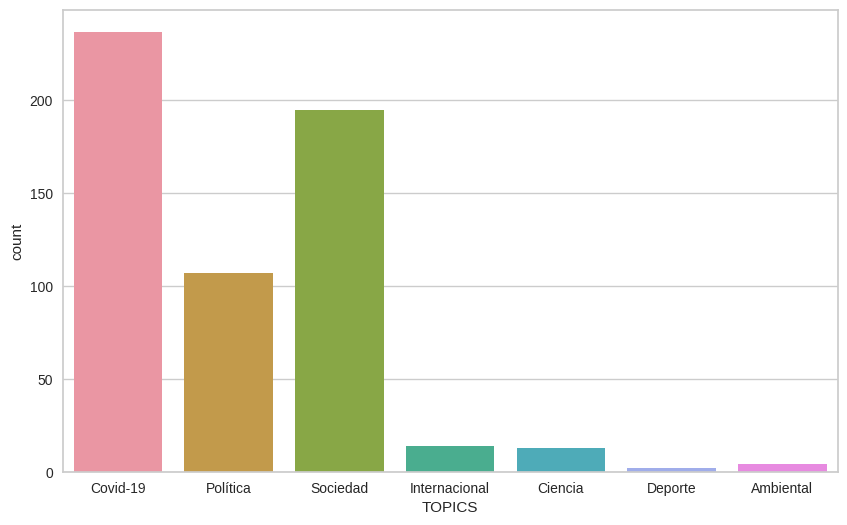

In [74]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'TOPICS', data = news_dataset)

In [75]:
news_dataset["SOURCE"].value_counts().count()

206

In [76]:

epa = news_dataset.query('CATEGORY == False')['SOURCE'].value_counts().count()
print(epa)
epa = news_dataset.query('CATEGORY == False')['SOURCE'].value_counts(normalize=True).mul(100).round(1)
print(epa.count())
epa.to_frame().style.bar()

118
118


,SOURCE
AFPFactual,31.500000
Mediterráneo Digital,5.600000
Maldita,3.500000
Agencia EFE,3.100000
El Dizque,2.800000
Facebook,2.400000
Alerta Digital,2.100000
,1.700000
El Diestro,1.400000
The Patriota,1.400000


In [77]:
epa = news_dataset.query('CATEGORY == True')['SOURCE'].value_counts()
print(epa.count())
epa.to_frame().style.bar()

99


,SOURCE
El Universal,28
Milenio,25
El País,20
El Financiero,15
BBC,13
BBC News,11
CNN,9
El Tiempo,9
El Economista,8
El Pais,7


<Axes: xlabel='TOPICS', ylabel='count'>

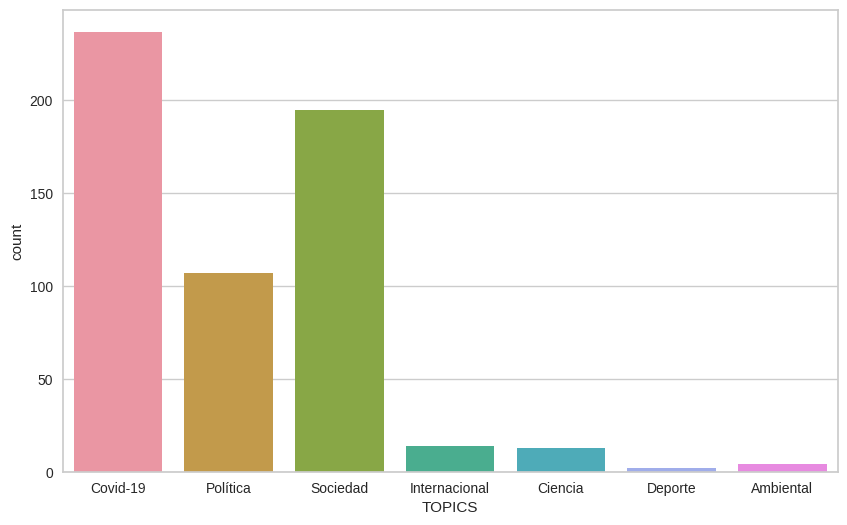

In [78]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'TOPICS', data = news_dataset)

In [79]:
# Descarga de stopwords en español
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Pre-procesamiento de la data

In [80]:
!python -m spacy download es_core_news_md


2023-08-24 05:37:54.967331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 10.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [81]:
def preprocess(content):

    preprocessed_content = re.sub('[^a-zA-ZñÑáéíóú]',' ',content)
    preprocessed_content = unidecode.unidecode(preprocessed_content)
    preprocessed_content = preprocessed_content.lower()
    preprocessed_content = preprocessed_content.split()
    preprocessed_content = [word for word in preprocessed_content if not word in stopwords.words('spanish')]
    preprocessed_content = ' '.join(preprocessed_content)
    nlp = spacy.load('es_core_news_md')
    document = nlp(preprocessed_content)
    preprocessed_content = ''
    for token in document:
      preprocessed_content = preprocessed_content + token.lemma_+ " "
    return preprocessed_content #[:-1]

In [82]:
frase = 'En su parte de arríba encontramos él ";zona de mandos";, donde se puede echar el detergente, aunque en nuestro caso lo al ser gel lo ponemos directamente junto con la ropa.'
preprocess(frase)

'parte arriba encontrar zona mando poder echar detergente aunque caso ser gel poner directamente junto ropa '

In [83]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(news_dataset['CATEGORY'])
label

array([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,

In [84]:
news_dataset.drop("CATEGORY", axis = 1, inplace=True)
news_dataset["VERDICT"] = label

In [85]:
news_dataset.head(5)

,ID,TOPICS,SOURCE,HEADLINE,TEXT,LINK,CONTENT,LENGHT,VERDICT
0,1,Covid-19,El Economista,Covid-19: mentiras que matan,El control de la Covid-19 no es sólo un tema d...,https://www.eleconomista.com.mx/opinion/Covid-...,Covid-19: mentiras que matan El control de la ...,4605,1
1,2,Política,El matinal,El Gobierno podrá acceder a las IPs de los móv...,El Gobierno de Pedro Sánchez y Pablo Iglesias ...,https://www.elmatinal.com/espana-ultima-hora/e...,El Gobierno podrá acceder a las IPs de los móv...,1916,0
2,3,Política,El País,La comunidad musulmana catalana denuncia a Vox...,Las tres federaciones que agrupan al 90% de la...,https://elpais.com/espana/elecciones-catalanas...,La comunidad musulmana catalana denuncia a Vox...,4195,1
3,4,Política,AFPFactual,,Se han dado a conocer los datos electorales pr...,https://perma.cc/GYE6-SPMB,Se han dado a conocer los datos electorales p...,1235,0
4,5,Sociedad,La Republica,El censo poblacional 2018 tendrá un costo de $...,La primera fase del censo será virtual y solo ...,https://www.larepublica.co/economia/el-censo-p...,El censo poblacional 2018 tendrá un costo de $...,1787,1


In [86]:
# Aplicamos el preprocess a la columna CONTENT
news_dataset['CONTENT'] = news_dataset['CONTENT'].apply(preprocess)
news_dataset.head()


,ID,TOPICS,SOURCE,HEADLINE,TEXT,LINK,CONTENT,LENGHT,VERDICT
0,1,Covid-19,El Economista,Covid-19: mentiras que matan,El control de la Covid-19 no es sólo un tema d...,https://www.eleconomista.com.mx/opinion/Covid-...,covid mentira matar control covid solo tema me...,4605,1
1,2,Política,El matinal,El Gobierno podrá acceder a las IPs de los móv...,El Gobierno de Pedro Sánchez y Pablo Iglesias ...,https://www.elmatinal.com/espana-ultima-hora/e...,gobierno podrir acceder ips movil sabrir nombr...,1916,0
2,3,Política,El País,La comunidad musulmana catalana denuncia a Vox...,Las tres federaciones que agrupan al 90% de la...,https://elpais.com/espana/elecciones-catalanas...,comunidad musulmán catalán denunciar vox incit...,4195,1
3,4,Política,AFPFactual,,Se han dado a conocer los datos electorales pr...,https://perma.cc/GYE6-SPMB,dado conocer dato electoral preliminar persona...,1235,0
4,5,Sociedad,La Republica,El censo poblacional 2018 tendrá un costo de $...,La primera fase del censo será virtual y solo ...,https://www.larepublica.co/economia/el-censo-p...,censo poblacional tendrir costo millón primero...,1787,1


covid mentira matar control covid solo tema medico resto personal sanitario cientifico desgracia fortuna asunto esencialmente politico decidir hombre mujer dedicar politico creencia opinión ultimo depender exito fracaso acción implementar exito tomar decisión salir vida nación obviamente error matar mas si estar acompanado mentira medio verdad pasado pulso salud febrero presidente lopez rompio record primero diez minuto habia decir tres mentira grave medio verdad tambien mentira problema mentira matar ocasion lopez obrador decir afortunadamente reducir contagio pais despues subsecretario lopez gatell camino complemento tesis ultima dos semana habia tendencia bajo verdad medio principio diciembre pasado varios experto habian supuesto luego buen fin fiesta conocido guadalupe reyes diciembre enero habriar pico contagio muerte luego regresariar siniestrar mortal meseta mas ocho mil contagio muerte promedio dia especular enero regresario numero principio diciembre asi efecto guadalupe reyes

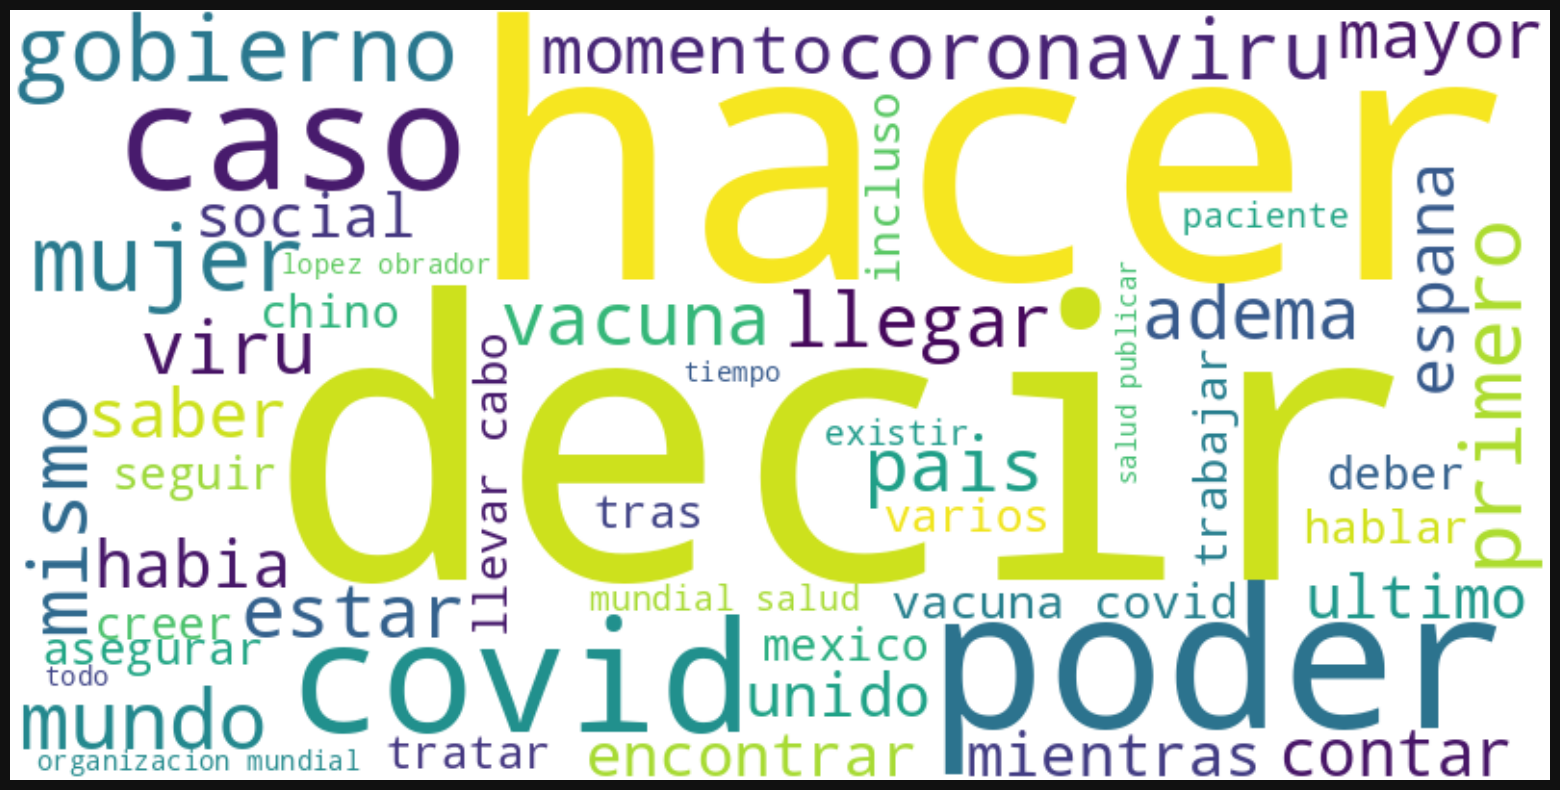

In [87]:
#Visualizar la data preprocesada
,
blacklist = ["parte", "solo", "anos", "cada", "paise", "embargo", "segun", "dijo", "importante", "cada", "bien", "ademas", "paise", "estudio", "tambien", "aunque", "ahora", "menos", "hace", "paises", "nuevo", "despues", "hombre", "persona", "hechos", "hecho"]
textwc = " ".join(i for i in news_dataset['CONTENT'])
datawc = ','.join(list(news_dataset['CONTENT'].values))
print(datawc)
wordcloud = WordCloud(background_color="white", max_words=50, min_word_length = 4, collocation_threshold = 7, width=800, height=400, stopwords = blacklist).generate(textwc)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')



In [88]:
#separating the data and label
X = news_dataset['CONTENT'].values
Y = news_dataset['VERDICT'].values


In [89]:
ngram_range = (1,3) # unigrams, bigrams, trigrams
min_df = 0.001 # se eliminan los terminos poco frecuentes que aparezcan como minimo en el 0.1% de los documentos
max_df = 0.9 # se eliminan los terminos demasiado frecuentes que aparezcan en almenos el 90% de los documentos (similar a stopwords).
max_features = 10000 # número de features en el dataset

In [90]:
# converting the textual data to numerical data

vectorizer = TfidfVectorizer(max_features = max_features, min_df = min_df, max_df = max_df)
vectorizer.get_params()
vectorizer.fit(X)
print(vectorizer.get_params())
X = vectorizer.transform(X)



{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.float64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 0.9, 'max_features': 10000, 'min_df': 0.001, 'ngram_range': (1, 1), 'norm': 'l2', 'preprocessor': None, 'smooth_idf': True, 'stop_words': None, 'strip_accents': None, 'sublinear_tf': False, 'token_pattern': '(?u)\\b\\w\\w+\\b', 'tokenizer': None, 'use_idf': True, 'vocabulary': None}


In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

In [92]:
X_train

<457x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 78364 stored elements in Compressed Sparse Row format>

### Logistic Regression



In [93]:
# Creación del modelo
LR_model = LogisticRegression()
LR_model.fit(X_train, Y_train)

LogisticRegression()

In [94]:
# Obtención de presición en base al training data
X_train_prediction_lr = LR_model.predict(X_train)
training_data_accuracy_lr = accuracy_score(X_train_prediction_lr, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy_lr)

# Obtención de presición en base al test data
X_test_prediction_lr = LR_model.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction_lr, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy_lr)

Accuracy score of the training data :  0.9824945295404814
Accuracy score of the test data :  0.6782608695652174


In [95]:
from sklearn.metrics import confusion_matrix

Text(48.88888888888888, 0.5, 'Predicho')

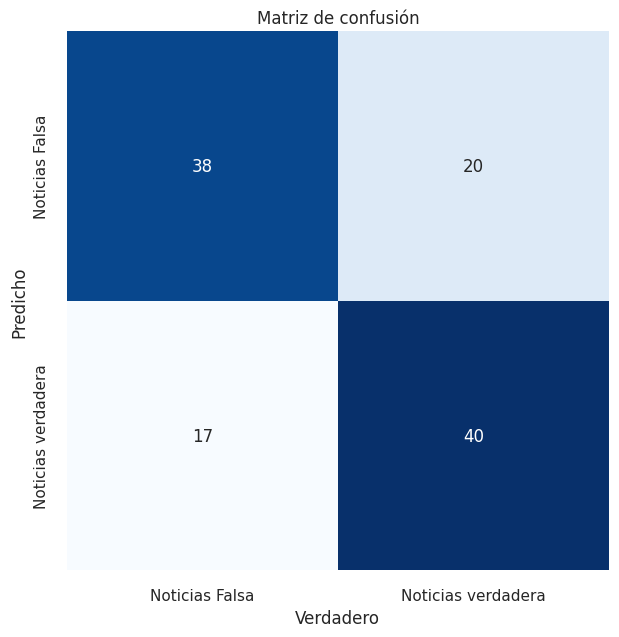

In [96]:
# Visualización
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(Y_test, X_test_prediction_lr)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Verdadero")
plt.ylabel("Predicho")

In [97]:
from sklearn.model_selection import RandomizedSearchCV

# Función para la busqueda de hiperparametros con RandomSearch
def randomsearchmodels(model,hyperparameters_tuning,X_train,Y_train,X_test,Y_test):
  gridsearch = RandomizedSearchCV(model,hyperparameters_tuning,n_iter=10,scoring='accuracy',cv=3,verbose=1,random_state=8)
  gridsearch.fit(X_train,Y_train)
  predictions = gridsearch.predict(X_test)
  accuracy_model=accuracy_score(predictions, Y_test)
  return gridsearch,predictions,accuracy_model

hyperparameters_tuning = {'C':np.logspace(-2,1,100),'penalty':['l2']}
best_model_logistic_cp,predictions_logistic_cp,accuracy_logistic_cp=randomsearchmodels(LogisticRegression(),hyperparameters_tuning,X_train,Y_train,X_test,Y_test)
print("Logistic Regression Accuracy Score -> ",accuracy_logistic_cp)
print("Mejores hiperparametros LR:",best_model_logistic_cp.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Logistic Regression Accuracy Score ->  0.6782608695652174
Mejores hiperparametros LR: {'penalty': 'l2', 'C': 0.07564633275546291}


### Naive Bayes

In [98]:
from sklearn.naive_bayes import MultinomialNB

# Creación del modelo
NB_model = MultinomialNB()
NB_model.fit(X_train, Y_train)

MultinomialNB()

In [99]:
# Obtención de presición en base al training data
X_train_prediction_nb = NB_model.predict(X_train)
training_data_accuracy_nb = accuracy_score(X_train_prediction_nb, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy_nb)

# Obtención de presición en base al test data
X_test_prediction_nb = NB_model.predict(X_test)
test_data_accuracy_nb = accuracy_score(X_test_prediction_nb, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy_nb)

Accuracy score of the training data :  0.9562363238512035
Accuracy score of the test data :  0.6434782608695652


Text(48.88888888888888, 0.5, 'Predicho')

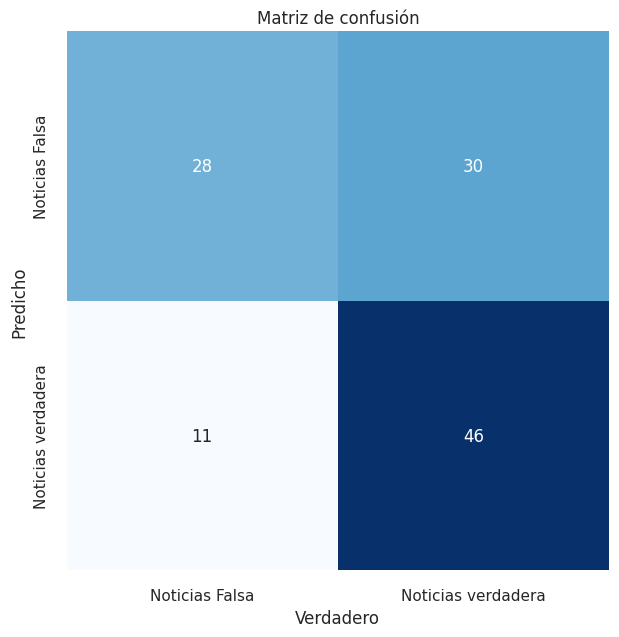

In [100]:
# Visualización
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(Y_test, X_test_prediction_nb)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Verdadero")
plt.ylabel("Predicho")

### Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier

# Creación del modelo
RF_model = RandomForestClassifier()
RF_model.fit(X_train, Y_train)

RandomForestClassifier()

In [102]:
# Obtención de presición en base al training data
X_train_prediction_rf = RF_model.predict(X_train)
training_data_accuracy_rf = accuracy_score(X_train_prediction_rf, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy_rf)

# Obtención de presición en base al test data
X_test_prediction_rf = RF_model.predict(X_test)
test_data_accuracy_rf = accuracy_score(X_test_prediction_rf, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy_rf)

Accuracy score of the training data :  1.0
Accuracy score of the test data :  0.6869565217391305


Text(48.88888888888888, 0.5, 'Predicho')

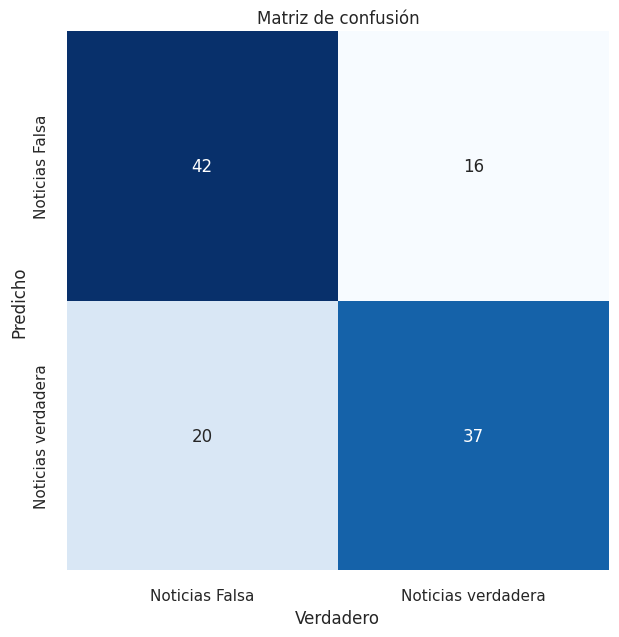

In [103]:
# Visualización
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(Y_test, X_test_prediction_rf)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Verdadero")
plt.ylabel("Predicho")

In [104]:
from sklearn.tree import DecisionTreeClassifier

# Creación del modelo
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, Y_train)

DecisionTreeClassifier()

In [105]:
# Obtención de presición en base al training data
X_train_prediction_dt = DT_model.predict(X_train)
training_data_accuracy_dt = accuracy_score(X_train_prediction_dt, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy_dt)

# Obtención de presición en base al test data
X_test_prediction_dt = DT_model.predict(X_test)
test_data_accuracy_dt = accuracy_score(X_test_prediction_dt, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy_dt)

Accuracy score of the training data :  1.0
Accuracy score of the test data :  0.591304347826087


Text(48.88888888888888, 0.5, 'Predicho')

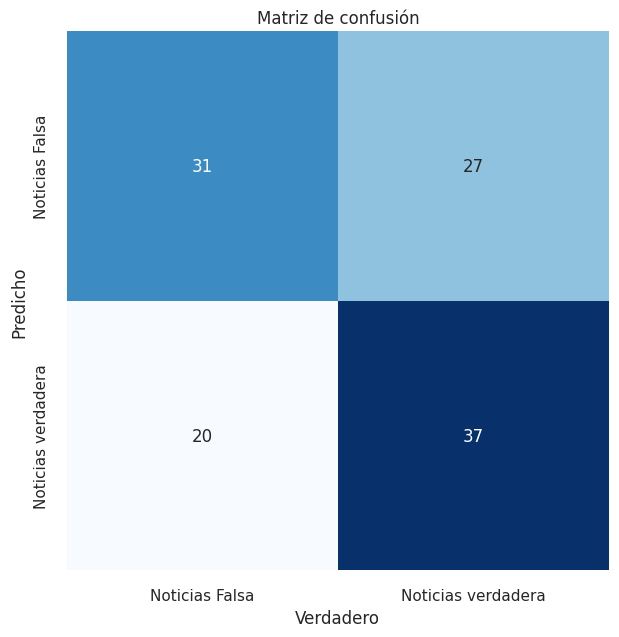

In [106]:
# Visualización
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(Y_test, X_test_prediction_dt)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Verdadero")
plt.ylabel("Predicho")

### K-Nearest Neighbors

In [107]:
from sklearn.neighbors import KNeighborsClassifier

# Creación del modelo
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train, Y_train)

KNeighborsClassifier()

In [108]:
# Obtención de presición en base al training data
X_train_prediction_knn = KNN_model.predict(X_train)
training_data_accuracy_knn = accuracy_score(X_train_prediction_knn, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy_knn)

# Obtención de presición en base al test data

X_test_prediction_knn = KNN_model.predict(X_test)
test_data_accuracy_knn = accuracy_score(X_test_prediction_knn, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy_knn)


Accuracy score of the training data :  0.6739606126914661
Accuracy score of the test data :  0.4956521739130435


Text(48.88888888888888, 0.5, 'Predicho')

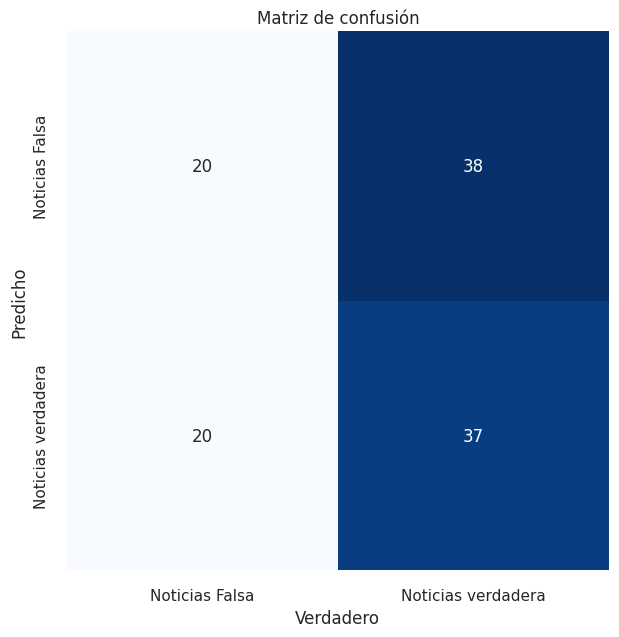

In [109]:
# Visualización
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(Y_test, X_test_prediction_knn)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Verdadero")
plt.ylabel("Predicho")

### Multi-layer Perceptron (MLP)

In [110]:
from sklearn.neural_network import MLPClassifier

# Creación del modelo
MLP_model = MLPClassifier() #hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1
MLP_model.fit(X_train, Y_train)

MLPClassifier()

In [111]:
# Obtención de presición en base al training data
X_train_prediction_mlp = MLP_model.predict(X_train)
training_data_accuracy_mlp = accuracy_score(X_train_prediction_mlp, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy_mlp)

# Obtención de presición en base al test data
X_test_prediction_mlp = MLP_model.predict(X_test)
test_data_accuracy_mlp = accuracy_score(X_test_prediction_mlp, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy_mlp)

Accuracy score of the training data :  1.0
Accuracy score of the test data :  0.6260869565217392


['VP\n31\n26.96%', 'FP\n27\n23.48%', 'FN\n16\n13.91%', 'VN\n41\n35.65%']


Text(0.5, 1.0, 'Matríz de confusión Matrix')

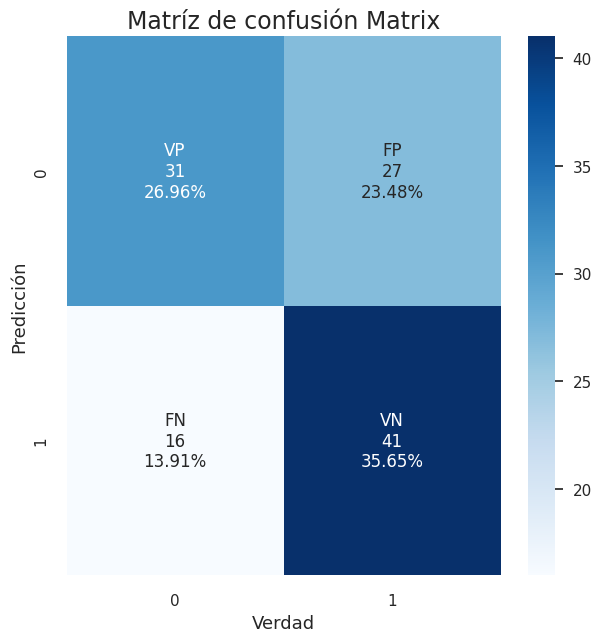

In [112]:
cf_matrix=confusion_matrix(Y_test, X_test_prediction_mlp)


#visualizar
categories = ['Noticia Falsa', 'Noticia Verdedera']
group_names = ['VP','FP', 'FN', 'VN']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

print(labels)
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.ylabel('Predicción',fontsize=13)
plt.xlabel('Verdad',fontsize=13)
plt.title('Matríz de confusión Matrix',fontsize=17)
